In [2]:
import requests

url = "https://esports-api.lolesports.com/persisted/gw/getLeagues?hl=en-US"
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36",
    "Accept": "application/x-mpegURL, application/vnd.apple.mpegurl, application/json, text/plain",
}
resp = requests.get(url, headers=headers)
print(resp.status_code)
print(resp.text)


403
{"message":"Forbidden"}


In [3]:
import requests
import json
from datetime import datetime

# Riot Esports API endpoint
url = "https://esports-api.lolesports.com/persisted/gw/getSchedule?leagueId=98767975604431411&hl=en-US"

# ⚠️ 如果你有自己的 Riot API Key，请填这里
headers = {
    "x-api-key": "0TvQnueqKa5mxJntVWt0w4LpLfEkrV1Ta8rQBb9Z"
}

# 请求数据
response = requests.get(url, headers=headers)
data = response.json()

matches = []

# 遍历所有比赛
for event in data["data"]["schedule"]["events"]:
    # 过滤出 2021 年的比赛
    if event.get("startTime", "").startswith("2021"):
        match_info = {
            "matchId": event.get("match", {}).get("id", "N/A"),
            "blockName": event.get("blockName", "N/A"),
            "startTime": event.get("startTime"),
            "teams": [],
            "winner": None
        }

        # 获取队伍信息
        if "match" in event and "teams" in event["match"]:
            for t in event["match"]["teams"]:
                team_name = t["name"]
                result = t.get("result", {}).get("outcome", "pending")
                match_info["teams"].append({
                    "name": team_name,
                    "result": result
                })
                if result == "win":
                    match_info["winner"] = team_name

        matches.append(match_info)

# 按时间排序
matches.sort(key=lambda x: x["startTime"])

# 打印结果
for m in matches:
    print(f"\n📅 {m['startTime']}")
    print(f"🏆 阶段: {m['blockName']}")
    print(f"🆚 {m['teams'][0]['name']} vs {m['teams'][1]['name']}")
    if m["winner"]:
        print(f"✅ 胜者: {m['winner']}")
    else:
        print("⏳ 比赛未开始或无结果")

# 保存为 JSON 文件
with open("worlds2021_matches.json", "w", encoding="utf-8") as f:
    json.dump(matches, f, ensure_ascii=False, indent=2)

print("\n✅ 已保存到 worlds2021_matches.json")



✅ 已保存到 worlds2021_matches.json


In [4]:
import requests
import time
import urllib.parse
import json
import pandas as pd

WIKI_API = "https://lol.fandom.com/api.php"

def mw_search(query, limit=5):
    """在 Leaguepedia 上搜索页面标题，返回 search results"""
    params = {
        "action": "query",
        "format": "json",
        "list": "search",
        "srsearch": query,
        "srlimit": limit
    }
    r = requests.get(WIKI_API, params=params)
    r.raise_for_status()
    return r.json()

def cargo_query(tables, fields, where=None, join_on=None, limit=500, offset=0):
    """用 cargoquery 查询数据（返回列表）"""
    params = {
        "action": "cargoquery",
        "format": "json",
        "tables": tables,
        "fields": fields,
        "limit": limit,
        "offset": offset
    }
    if where:
        params["where"] = where
    if join_on:
        params["join_on"] = join_on

    r = requests.get(WIKI_API, params=params)
    r.raise_for_status()
    return r.json()

def find_data_page_for_tournament(tournament_name):
    """尝试找到 Data: 开头的数据页面（返回第一个猜测的 Data: 页面名）"""
    # 先在 wiki 搜索 tournament_name
    res = mw_search(tournament_name, limit=10)
    titles = [s["title"] for s in res["query"]["search"]]
    # 尝试构造 Data: 前缀的页面名候选
    candidates = []
    for t in titles:
        # 常见的 Data 页面命名规则： Data:{page title} 或 Data:{page title} (有时带 Season)
        candidates.append("Data:" + t)
        # 也尝试把 "2021 Season World Championship" 风格直接拼接
        if "World" in t or "Worlds" in t or "World Championship" in t:
            candidates.append("Data:" + t.replace(" ", " "))
    # 逐个测试是否有这个页面（用 cargo 查询来检验是否能匹配到数据）
    for c in candidates:
        # 简单检查：尝试用Cargo查询 MatchScheduleGame 表过滤该 _pageName
        where = 'MSG._pageName="%s"' % c
        try:
            resp = cargo_query(
                tables="MatchScheduleGame=MSG",
                fields="MSG.OverviewPage",
                where=where,
                limit=1
            )
            if resp.get("cargoquery"):
                return c
        except Exception:
            pass
        time.sleep(0.3)
    return None

def fetch_worlds_2021_matches():
    # 1) 找到一个可能的 Data 页面
    # 我们首先搜索常见名字
    possible_names = ["2021 Season World Championship", "2021 World Championship", "2021_Season_World_Championship", "2021 Season Worlds", "2021 Season Worlds"]
    data_page = None
    for name in possible_names:
        cand = find_data_page_for_tournament(name)
        if cand:
            data_page = cand
            print("找到 Data 页面：", data_page)
            break
    if not data_page:
        # 进一步尝试直接搜索 "2021 Season World Championship" 并 take first search hit
        print("初步候选未命中，直接搜索 wiki 页面并尝试 Data: 前缀")
        s = mw_search("2021 World Championship", limit=5)
        if s["query"]["search"]:
            page_title = s["query"]["search"][0]["title"]
            data_page_guess = "Data:" + page_title
            print("尝试猜测 Data 页面：", data_page_guess)
            data_page = data_page_guess

    if not data_page:
        raise RuntimeError("未能确定 Data 页面，请手动确认 Leaguepedia 上该赛事的 Data 页面名（例如 Data:2021 Season World Championship）")

    # 2) 用 Cargo 查询 MatchScheduleGame (MSG) / ScoreboardGames 或 ScoreboardGames 表里有关 RiotPlatformGameId 的条目
    # 下面用 MatchScheduleGame (MSG) 表为例，提取 RiotPlatformGameId、Team1、Team2、DateTime_UTC
    tables = "MatchScheduleGame=MSG, MatchSchedule=MS"
    # 选择字段（可以根据需要扩展）
    fields = ",".join([
        "MSG.OverviewPage",
        "MSG.RiotPlatformGameId",
        "MSG.Team1",
        "MSG.Team2",
        "MS.Name",
        "MSG.DateTime_UTC",
        "MSG.N_MatchInPage",
        "MSG.N_GameInMatch"
    ])
    where = 'MSG._pageName="%s" AND MSG.RiotPlatformGameId IS NOT NULL' % data_page
    join_on = "MSG.MatchId=MS.MatchId"
    offset = 0
    limit = 500
    rows = []
    while True:
        print(f"查询 cargo offset={offset} ...")
        resp = cargo_query(tables=tables, fields=fields, where=where, join_on=join_on, limit=limit, offset=offset)
        cargo = resp.get("cargoquery", [])
        if not cargo:
            break
        for item in cargo:
            rows.append(item["title"])
        if len(cargo) < limit:
            break
        offset += limit
        time.sleep(1)

    # 3) 整理并返回 DataFrame
    if not rows:
        print("未在 Cargo 表中找到任何 RiotPlatformGameId；请确认 Data 页面名与表/字段是否正确。")
        return None

    df = pd.DataFrame(rows)
    # 简单清理：有些字段可能为空
    df = df.rename(columns=lambda c: c.strip())
    # 导出 CSV
    df.to_csv("worlds2021_leaguepedia_matches.csv", index=False, encoding="utf-8-sig")
    print("已保存到 worlds2021_leaguepedia_matches.csv，行数:", len(df))
    return df

if __name__ == "__main__":
    df = fetch_worlds_2021_matches()
    if df is not None:
        print(df.head())


找到 Data 页面： Data:2021 Season World Championship/Play-In
查询 cargo offset=0 ...
未在 Cargo 表中找到任何 RiotPlatformGameId；请确认 Data 页面名与表/字段是否正确。


In [36]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

BASE = "https://lol.fandom.com"

# 1️⃣ 获取 Data 页面
data_page_url = "https://lol.fandom.com/wiki/Data:2021_Season_World_Championship/Play-In"
resp = requests.get(data_page_url)
soup = BeautifulSoup(resp.text, "html.parser")

# 2️⃣ 获取所有比赛 OverviewPage 链接
matches = []
for link in soup.select("table.wikitable a"):
    href = link.get("href")
    if href and "/Play-In/" in href:
        matches.append(BASE + href)

print(f"找到 {len(matches)} 场比赛")

# 3️⃣ 遍历每场比赛
rows = []
for idx, url in enumerate(matches):
    print(f"爬第 {idx+1} 场比赛: {url}")
    r = requests.get(url)
    s = BeautifulSoup(r.text, "html.parser")

    # 红蓝方队伍
    blue = s.select_one(".team-left .team-template-text").text.strip() if s.select_one(".team-left .team-template-text") else "N/A"
    red  = s.select_one(".team-right .team-template-text").text.strip() if s.select_one(".team-right .team-template-text") else "N/A"

    # 胜方（根据 class 或文本判断）
    winner = None
    if s.select_one(".team-left.winner"):
        winner = blue
    elif s.select_one(".team-right.winner"):
        winner = red

    # picks/bans（可选，这里简单抓每方英雄名字）
    blue_picks = [hero.text.strip() for hero in s.select(".team-left .champion")]
    red_picks  = [hero.text.strip() for hero in s.select(".team-right .champion")]

    rows.append({
        "match_url": url,
        "blue_team": blue,
        "red_team": red,
        "winner": winner,
        "blue_picks": ",".join(blue_picks),
        "red_picks": ",".join(red_picks)
    })
    time.sleep(0.5)  # 避免过快请求

# 4️⃣ 保存 CSV / JSON
df = pd.DataFrame(rows)
df.to_csv("worlds2021_playin_bp.csv", index=False, encoding="utf-8-sig")
df.to_json("worlds2021_playin_bp.json", orient="records", force_ascii=False)
print("✅ 已保存 CSV/JSON")


找到 0 场比赛
✅ 已保存 CSV/JSON


------------

# 处理数据

In [15]:
import pandas as pd

# 读取数据
df = pd.read_csv("./esports dataset/my/games_player_champion_combined.csv")

# 初始化字典统计胜负
player_stats = {}

# 遍历每一场比赛
for idx, row in df.iterrows():
    # 胜方玩家
    for p in row[['win1','win2','win3','win4','win5']]:
        if p != "_NOOB_" and pd.notna(p):
            if p not in player_stats:
                player_stats[p] = {'win':0, 'total':0}
            player_stats[p]['win'] += 1
            player_stats[p]['total'] += 1
    # 败方玩家
    for p in row[['lose1','lose2','lose3','lose4','lose5']]:
        if p != "_NOOB_" and pd.notna(p):
            if p not in player_stats:
                player_stats[p] = {'win':0, 'total':0}
            player_stats[p]['total'] += 1

# 转成 DataFrame，包括胜场数、总场数和胜率
data = []
for p, stats in player_stats.items():
    win = stats['win']
    total = stats['total']
    winrate = win / total if total > 0 else 0
    data.append({'player': p, 'win': win, 'total': total, 'winrate': round(winrate, 3)})

df_winrate = pd.DataFrame(data)
df_winrate = df_winrate.sort_values(by='winrate', ascending=False)

# 保存结果
df_winrate.to_csv("player_winrate_with_counts.csv", index=False, encoding="utf-8-sig")
print(df_winrate)


            player  win  total  winrate
0    Tactical_暴走萝莉    1      1      1.0
727    Crisp_魂锁典狱长    1      1      1.0
700    Trymbi_法外狂徒    1      1      1.0
701       FBI_残月之肃    3      3      1.0
705  Gumayusi_暗夜猎手    1      1      1.0
..             ...  ...    ...      ...
680   Humanoid_戏命师    0      1      0.0
943    Chovy_猩红收割者    0      1      0.0
942      Clid_影流之镰    0      1      0.0
683    Iwandy_无双剑姬    0      1      0.0
420     Viper_复仇焰魂    0      1      0.0

[1247 rows x 4 columns]


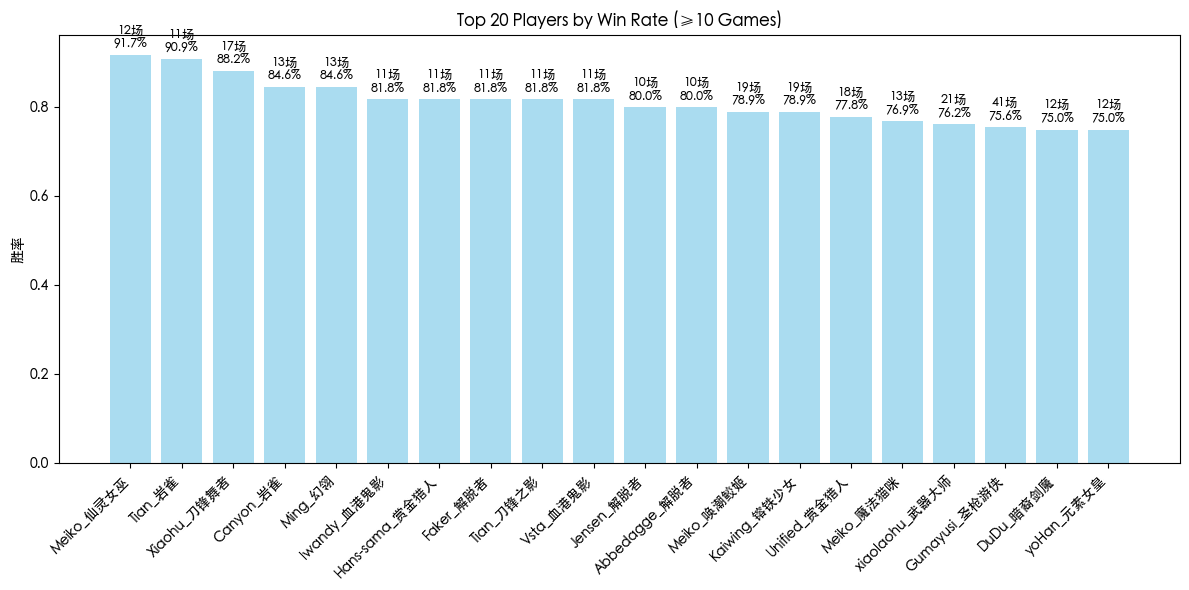

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager

plt.rcParams['font.family'] = 'Heiti TC'  # 替换为你选择的字体

# 读取数据
df = pd.read_csv("./Esports dataset/my/player_winrate_with_counts.csv")
df = df[df['total'] >= 10]
top = df.sort_values(by='winrate', ascending=False).head(20)

plt.figure(figsize=(12,6))
bars = plt.bar(top['player'], top['winrate'], alpha=0.7, color='skyblue')

for bar, total, winrate in zip(bars, top['total'], top['winrate']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{int(total)}场\n{winrate*100:.1f}%", 
             ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.ylabel("胜率")
plt.title("Top 20 Players by Win Rate (≥10 Games)")
plt.tight_layout()
plt.show()


In [29]:
import pandas as pd

# 读取 CSV
df = pd.read_csv("./esports dataset/my/games_player_champion_combined.csv")

# 定义位置列
win_cols = ['win1','win2','win3','win4','win5']
lose_cols = ['lose1','lose2','lose3','lose4','lose5']

# ==== 1️⃣ 按位置统计玩家胜率 ====
position_player_stats = {i: {} for i in range(5)}  # 0~4位置

for idx, row in df.iterrows():
    for i in range(5):
        # 胜方
        p_champ = row[win_cols[i]]
        if pd.notna(p_champ) and p_champ != "_NOOB_":
            player, _ = p_champ.split('_')
            stats = position_player_stats[i].setdefault(player, {'win':0,'total':0})
            stats['win'] += 1
            stats['total'] += 1
        # 败方
        p_champ = row[lose_cols[i]]
        if pd.notna(p_champ) and p_champ != "_NOOB_":
            player, _ = p_champ.split('_')
            stats = position_player_stats[i].setdefault(player, {'win':0,'total':0})
            stats['total'] += 1

# 转 DataFrame 并排序，筛选 total ≥ 20
position_player_df = {}
for i in range(5):
    data = []
    for player, stats in position_player_stats[i].items():
        if stats['total'] >= 20:  # 筛选总场次≥20
            winrate = stats['win'] / stats['total'] if stats['total']>0 else 0
            data.append({'player': player, 'win': stats['win'], 'total': stats['total'], 'winrate': round(winrate,3)})
    df_pos = pd.DataFrame(data).sort_values(by='winrate', ascending=False)
    position_player_df[i+1] = df_pos  # 位置编号 1~5
    print(f"=== 位置{i+1} 玩家胜率排名（总场次≥20） ===")
    print(df_pos.head(10), '\n')  # 打印前10名

# ==== 2️⃣ 按位置统计英雄胜率 ====
position_champ_stats = {i: {} for i in range(5)}

for idx, row in df.iterrows():
    for i in range(5):
        # 胜方
        p_champ = row[win_cols[i]]
        if pd.notna(p_champ) and p_champ != "_NOOB_":
            _, champ = p_champ.split('_')
            stats = position_champ_stats[i].setdefault(champ, {'win':0,'total':0})
            stats['win'] += 1
            stats['total'] += 1
        # 败方
        p_champ = row[lose_cols[i]]
        if pd.notna(p_champ) and p_champ != "_NOOB_":
            _, champ = p_champ.split('_')
            stats = position_champ_stats[i].setdefault(champ, {'win':0,'total':0})
            stats['total'] += 1

# 转 DataFrame 并排序（只保留总场次≥8的英雄）
position_champ_df = {}
for i in range(5):
    data = []
    for champ, stats in position_champ_stats[i].items():
        if stats['total'] >= 10:
            winrate = stats['win']/stats['total']
            data.append({'champion': champ, 'win': stats['win'], 'total': stats['total'], 'winrate': round(winrate,3)})
    df_pos = pd.DataFrame(data).sort_values(by='winrate', ascending=False).head(5)
    position_champ_df[i+1] = df_pos
    print(f"=== 位置{i+1} 英雄胜率 Top5（总场次≥8） ===")
    print(df_pos, '\n')


=== 位置1 玩家胜率排名（总场次≥20） ===
       player  win  total  winrate
3       Canna   50     68    0.735
1      Xiaohu   66     96    0.688
14    Odoamne   21     32    0.656
5         Ale   36     55    0.655
15     Morgan   31     48    0.646
4   xiaolaohu   73    118    0.619
2      Nuguri   82    134    0.612
9        Khan   47     78    0.603
13     Hanabi   45     75    0.600
11       DuDu   50     85    0.588 

=== 位置2 玩家胜率排名（总场次≥20） ===
    player  win  total  winrate
6     Tian   69     91    0.758
14  Closer   32     46    0.696
12   yoHan   19     28    0.679
3      Wei   71    105    0.676
0   Jiejie   63     95    0.663
2     Oner   64    101    0.634
8     Clid   64    106    0.604
1   Canyon   51     85    0.600
9    River   26     44    0.591
13  Willer   24     41    0.585 

=== 位置3 玩家胜率排名（总场次≥20） ===
       player  win  total  winrate
1   ShowMaker   54     74    0.730
7       Nisqy   36     52    0.692
0         Bdd   30     46    0.652
4   Abbedagge   31     49    0.633
12 

/downarrow

In [35]:
import pandas as pd

# 读取 CSV
df = pd.read_csv("./esports dataset/my/games_player_champion_combined.csv")

win_cols = ['win1','win2','win3','win4','win5']
lose_cols = ['lose1','lose2','lose3','lose4','lose5']

# 位置映射
pos_map = {0:'上单', 1:'打野', 2:'中单', 3:'ADC', 4:'辅助'}

# ==== 1️⃣ 按位置统计玩家胜率 ====
position_player_stats = {i: {} for i in range(5)}

for idx, row in df.iterrows():
    for i in range(5):
        # 胜方
        p_champ = row[win_cols[i]]
        if pd.notna(p_champ) and p_champ != "_NOOB_":
            player, _ = p_champ.split('_')
            stats = position_player_stats[i].setdefault(player, {'win':0,'total':0})
            stats['win'] += 1
            stats['total'] += 1
        # 败方
        p_champ = row[lose_cols[i]]
        if pd.notna(p_champ) and p_champ != "_NOOB_":
            player, _ = p_champ.split('_')
            stats = position_player_stats[i].setdefault(player, {'win':0,'total':0})
            stats['total'] += 1

# ==== 2️⃣ 按位置统计英雄胜率 & 英雄选择次数 ====
position_champ_stats = {i:{} for i in range(5)}

for idx, row in df.iterrows():
    for i in range(5):
        # 胜方
        p_champ = row[win_cols[i]]
        if pd.notna(p_champ) and p_champ != "_NOOB_":
            _, champ = p_champ.split('_')
            stats = position_champ_stats[i].setdefault(champ, {'win':0,'total':0})
            stats['win'] += 1
            stats['total'] += 1
        # 败方
        p_champ = row[lose_cols[i]]
        if pd.notna(p_champ) and p_champ != "_NOOB_":
            _, champ = p_champ.split('_')
            stats = position_champ_stats[i].setdefault(champ, {'win':0,'total':0})
            stats['total'] += 1

# ==== 写入 TXT 文件 ====
with open("position_stats.txt", "w", encoding="utf-8") as f:
    for i in range(5):
        pos_name = pos_map[i]  # 使用位置名称
        
        # 玩家胜率排名（总场次≥20）
        data = []
        for player, stats in position_player_stats[i].items():
            if stats['total'] >= 20:
                winrate = stats['win'] / stats['total']
                data.append({'player': player, 'win': stats['win'], 'total': stats['total'], 'winrate': round(winrate,3)})
        df_pos = pd.DataFrame(data).sort_values(by='winrate', ascending=False)
        f.write(f"=== {pos_name} 玩家胜率排名（总场次≥20） ===\n")
        f.write(df_pos.head(10).to_string(index=False))
        f.write("\n\n")
        
        # 英雄胜率前5（总场次≥20）
        champ_data = []
        for champ, stats in position_champ_stats[i].items():
            if stats['total'] >= 20:
                winrate = stats['win'] / stats['total']
                champ_data.append({'champion': champ, 'win': stats['win'], 'total': stats['total'], 'winrate': round(winrate,3)})
        df_champ_win = pd.DataFrame(champ_data).sort_values(by='winrate', ascending=False).head(5)
        f.write(f"=== {pos_name} 英雄胜率前5（总场次≥20） ===\n")
        f.write(df_champ_win.to_string(index=False))
        f.write("\n\n")

        # 英雄选择次数前5（总场次≥20）
        df_champ_count = pd.DataFrame(champ_data).sort_values(by='total', ascending=False).head(5)
        f.write(f"=== {pos_name} 英雄选择次数前5（总场次≥20） ===\n")
        f.write(df_champ_count.to_string(index=False))
        f.write("\n\n")

print("✅ 已生成 position_stats.txt")


✅ 已生成 position_stats.txt


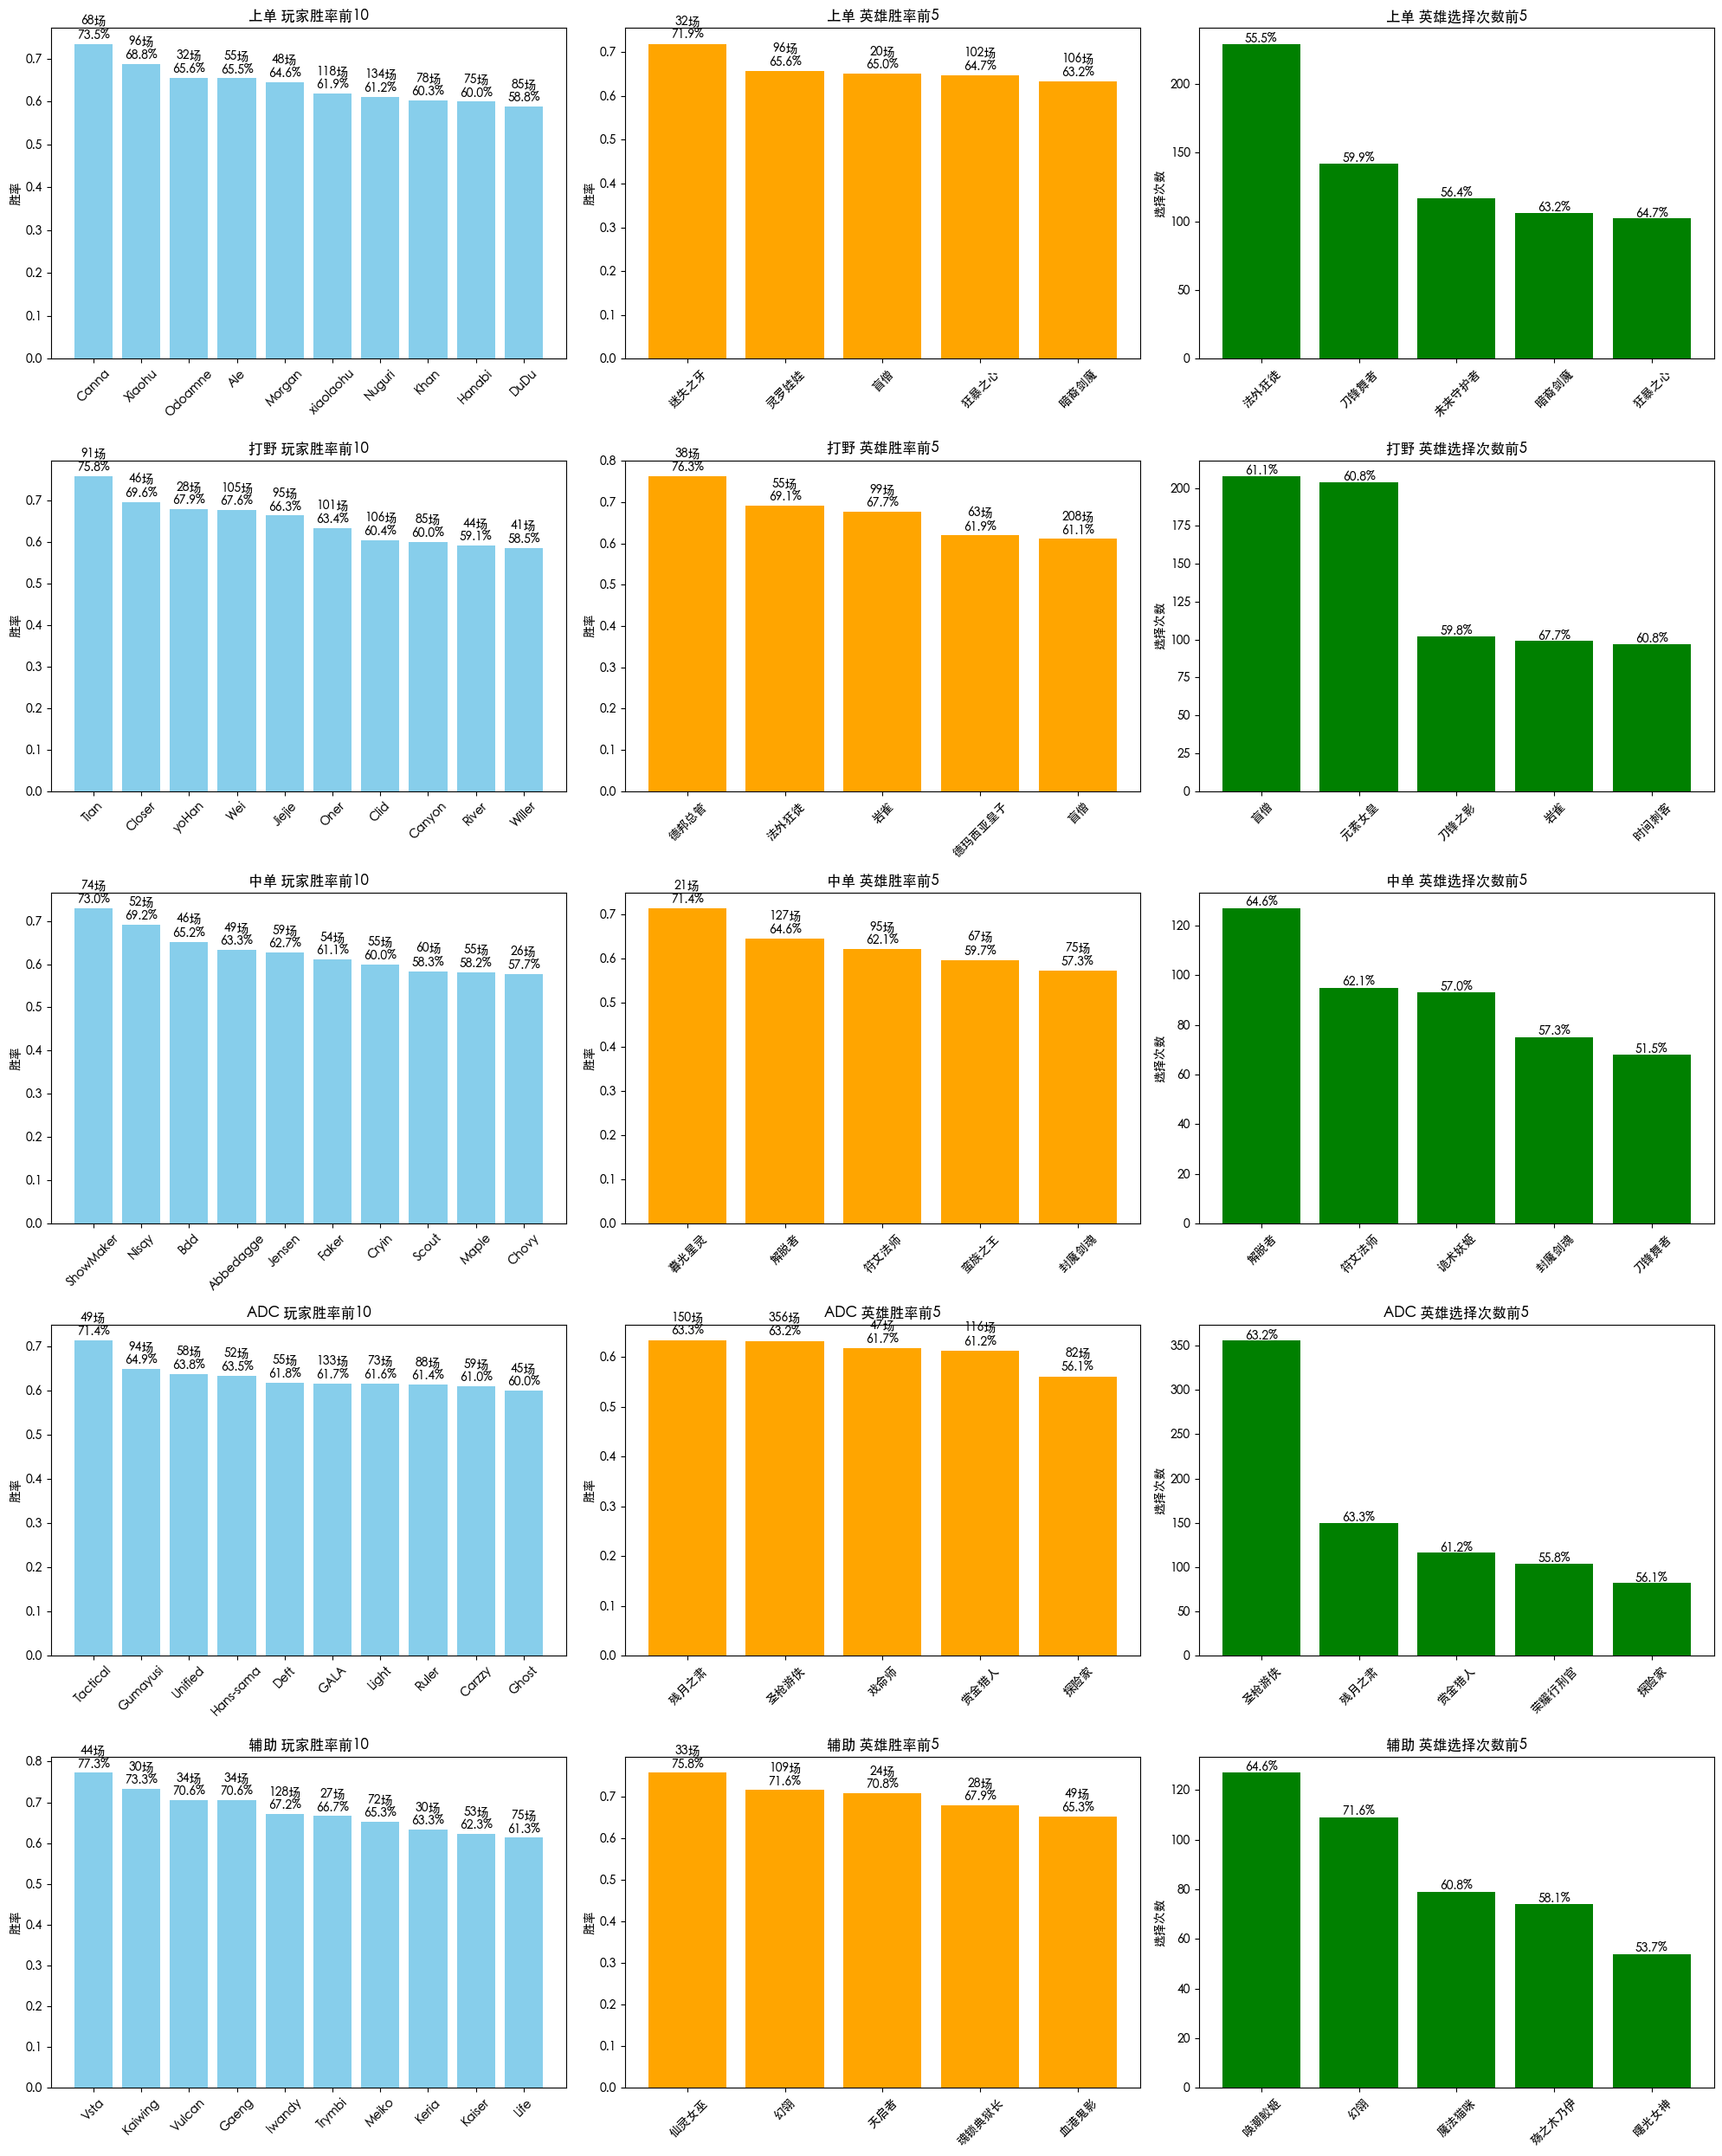

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 中文字体
plt.rcParams['font.family'] = 'Heiti TC'  # 替换为你选择的字体

# 读取数据
df = pd.read_csv("./esports dataset/my/games_player_champion_combined.csv")
win_cols = ['win1','win2','win3','win4','win5']
lose_cols = ['lose1','lose2','lose3','lose4','lose5']
pos_map = {0:'上单', 1:'打野', 2:'中单', 3:'ADC', 4:'辅助'}

# 统计数据
position_player_stats = {i:{} for i in range(5)}
position_champ_stats = {i:{} for i in range(5)}

for idx, row in df.iterrows():
    for i in range(5):
        for col in [win_cols[i], lose_cols[i]]:
            val = row[col]
            if pd.notna(val) and val != "_NOOB_":
                player, champ = val.split('_')
                stats_player = position_player_stats[i].setdefault(player, {'win':0,'total':0})
                stats_champ = position_champ_stats[i].setdefault(champ, {'win':0,'total':0})
                if col in win_cols:
                    stats_player['win'] +=1
                    stats_champ['win'] +=1
                stats_player['total'] +=1
                stats_champ['total'] +=1

# 绘图
fig, axes = plt.subplots(5, 3, figsize=(20,25))
plt.subplots_adjust(hspace=0.6)

for i in range(5):
    # 玩家胜率前10
    data_player = [{'player': p, 'win': s['win'], 'total': s['total'], 'winrate': s['win']/s['total']}
                   for p,s in position_player_stats[i].items() if s['total']>=20]
    df_player = pd.DataFrame(data_player).sort_values(by='winrate', ascending=False).head(10)
    axes[i,0].bar(df_player['player'], df_player['winrate'], color='skyblue')
    axes[i,0].set_title(f"{pos_map[i]} 玩家胜率前10")
    axes[i,0].set_ylabel("胜率")
    axes[i,0].tick_params(axis='x', rotation=45)
    for idx,row in enumerate(df_player.itertuples()):
        axes[i,0].text(idx, row.winrate+0.01, f"{row.total}场\n{row.winrate*100:.1f}%", ha='center')

    # 英雄胜率前5
    data_champ = [{'champion': c, 'win': s['win'], 'total': s['total'], 'winrate': s['win']/s['total']}
                  for c,s in position_champ_stats[i].items() if s['total']>=20]
    df_champ_win = pd.DataFrame(data_champ).sort_values(by='winrate', ascending=False).head(5)
    axes[i,1].bar(df_champ_win['champion'], df_champ_win['winrate'], color='orange')
    axes[i,1].set_title(f"{pos_map[i]} 英雄胜率前5")
    axes[i,1].set_ylabel("胜率")
    axes[i,1].tick_params(axis='x', rotation=45)
    for idx,row in enumerate(df_champ_win.itertuples()):
        axes[i,1].text(idx, row.winrate+0.01, f"{row.total}场\n{row.winrate*100:.1f}%", ha='center')

    # 英雄选择次数前5
    df_champ_count = pd.DataFrame(data_champ).sort_values(by='total', ascending=False).head(5)
    axes[i,2].bar(df_champ_count['champion'], df_champ_count['total'], color='green')
    axes[i,2].set_title(f"{pos_map[i]} 英雄选择次数前5")
    axes[i,2].set_ylabel("选择次数")
    axes[i,2].tick_params(axis='x', rotation=45)
    for idx,row in enumerate(df_champ_count.itertuples()):
        axes[i,2].text(idx, row.total+0.5, f"{row.winrate*100:.1f}%", ha='center')

plt.tight_layout()
plt.show()
